# 3. Regresión: Predicción del Gasto/Valor de Vivienda

### 3.1. Objetivo y Dataset
El objetivo es entrenar un modelo de aprendizaje supervisado capaz de **predecir el valor mediano de una casa** en California basándose en características del vecindario.

**Dataset:** `sklearn.datasets.fetch_california_housing`
* **Registros:** 20,640 zonas censales.
* **Variable Objetivo ($y$):** `MedHouseVal` (Valor mediano de la casa en unidades de $100,000 USD).
* **Variables Predictoras ($X$):** Ingreso mediano, antigüedad, habitaciones promedio, ocupación, ubicación (lat/long), etc.

**Algoritmo:** **Regresión Ridge**.
* Se eligió este modelo porque introduce un término de regularización ($L2$) que penaliza los coeficientes grandes, ayudando a reducir el sobreajuste (*overfitting*) y manejando mejor la multicolinealidad entre variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# 1. Cargar datos
housing = fetch_california_housing(as_frame=True)
df = housing.frame

# 2. Exploración básica
print(f"Dimensiones: {df.shape}")
display(df.head())
display(df.describe().round(2))

Dimensiones: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00,20640.00
mean,3.87,28.64,5.43,1.10,1425.48,3.07,35.63,-119.57,2.07
std,1.90,12.59,2.47,0.47,1132.46,10.39,2.14,2.00,1.15
min,0.50,1.00,0.85,0.33,3.00,0.69,32.54,-124.35,0.15
25%,2.56,18.00,4.44,1.01,787.00,2.43,33.93,-121.80,1.20
50%,3.53,29.00,5.23,1.05,1166.00,2.82,34.26,-118.49,1.80
75%,4.74,37.00,6.05,1.10,1725.00,3.28,37.71,-118.01,2.65
max,15.00,52.00,141.91,34.07,35682.00,1243.33,41.95,-114.31,5.00


### 3.2. Preprocesamiento de Datos

Un paso crítico para la **Regresión Ridge** es el **Escalado de Características**.

A diferencia de la regresión lineal simple, Ridge es sensible a la magnitud de las variables. Si una variable tiene valores grandes (ej. `Population`: 2000) y otra pequeños (ej. `AveRooms`: 5), el modelo dará un peso desproporcionado a la variable más grande.

* **Solución:** Aplicamos `StandardScaler` para normalizar todas las variables (media=0, desviación=1) antes del entrenamiento.

R² Score: 0.5758
RMSE:     0.7456


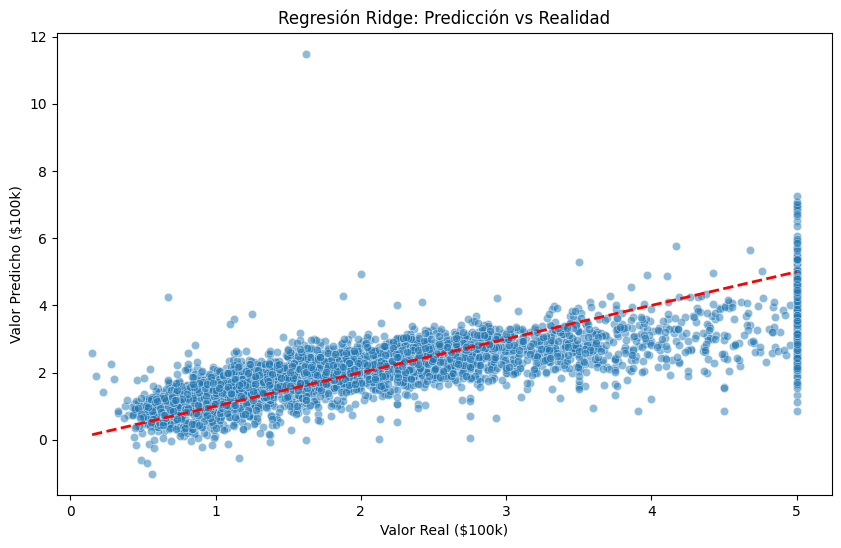

In [2]:
# 1. Separar X e y
X = df.drop(columns=['MedHouseVal'])
y = df['MedHouseVal']

# 2. División Train/Test (80% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Escalado (Fit solo en Train para evitar data leakage)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Entrenamiento (Ridge con alpha=1.0)
model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train_scaled, y_train)

# 5. Predicción y Métricas
y_pred = model_ridge.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"RMSE:     {rmse:.4f}")

# 6. Gráfica de Real vs Predicho
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Valor Real ($100k)')
plt.ylabel('Valor Predicho ($100k)')
plt.title('Regresión Ridge: Predicción vs Realidad')
plt.show()

### 3.3. Análisis de Resultados

Tras evaluar el modelo en el conjunto de prueba, se obtuvieron los siguientes resultados:

* **$R^2$ (Coeficiente de Determinación): 0.5758**.
    * Esto indica que el modelo es capaz de explicar el **57.58% de la variabilidad** en el precio de las casas. Es un rendimiento moderado aceptable considerando que solo usamos características básicas del censo sin ingeniería avanzada.
* **RMSE (Raíz del Error Cuadrático Medio): 0.7456**.
    * Dado que la variable objetivo está en unidades de $100,000 USD, esto significa que el modelo tiene un **error promedio de aprox. $74,560 USD** en sus predicciones.

### 3.4. Sistema de Predicción

A continuación, se implementa la función requerida para predecir el precio de nuevas viviendas fácilmente.

In [3]:
def predecir_casa(datos):
    """
    Recibe un diccionario con las características, las escala y predice el precio.
    """
    # Convertir a DataFrame
    nueva_df = pd.DataFrame([datos])
    
    # Escalar (Usando el scaler ya entrenado)
    nueva_scaled = scaler.transform(nueva_df)
    
    # Predecir
    pred = model_ridge.predict(nueva_scaled)
    precio_usd = pred[0] * 100000
    
    return precio_usd

# --- PRUEBA DEL SISTEMA ---
# Datos de ejemplo (Zona de ingresos medios)
casa_ejemplo = {
    'MedInc': 5.0,        # Ingreso medio
    'HouseAge': 20.0,     # Antigüedad
    'AveRooms': 6.0,      # Habitaciones promedio
    'AveBedrms': 1.0,     # Dormitorios promedio
    'Population': 1000.0, # Población
    'AveOccup': 3.0,      # Ocupantes promedio
    'Latitude': 34.0,     # Latitud
    'Longitude': -118.0   # Longitud
}

precio = predecir_casa(casa_ejemplo)
print(f"🏡 Características de la casa: {casa_ejemplo}")
print("-" * 50)
print(f"💰 PRECIO PREDICHO: ${precio:,.2f} USD")

🏡 Características de la casa: {'MedInc': 5.0, 'HouseAge': 20.0, 'AveRooms': 6.0, 'AveBedrms': 1.0, 'Population': 1000.0, 'AveOccup': 3.0, 'Latitude': 34.0, 'Longitude': -118.0}
--------------------------------------------------
💰 PRECIO PREDICHO: $234,981.59 USD
